- Import libraries
- Read the data
- Preprocessing 
    - Fill nan
    - Dropping clients with only a few records
- Select the features
- Shift the labels (next month prediction)
- Classification
    


In [79]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

from sklearn import metrics
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_det_curve
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import train_test_split

from sklearn.metrics import plot_confusion_matrix
import pickle

%matplotlib inline
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

plt.rcParams['figure.figsize'] = [8, 6]

pd.options.mode.chained_assignment = None  # default='warn'

## Read the data

#### Load and explore the data

In [80]:
# # -- read credit applications data

crdt_applctn = pd.read_csv("./data/credit_applications.csv", index_col=0)
crdt_applctn.head()

,client_nr,yearmonth,credit_application,nr_credit_applications
1,1,201401,0,0
2,1,201402,0,0
3,1,201403,0,0
4,1,201404,0,0
5,1,201405,0,0


In [81]:
# # -- a quick summary 

crdt_applctn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29996 entries, 1 to 29996
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   client_nr               29996 non-null  int64
 1   yearmonth               29996 non-null  int64
 2   credit_application      29996 non-null  int64
 3   nr_credit_applications  29996 non-null  int64
dtypes: int64(4)
memory usage: 1.1 MB


In [82]:
# # -- ratio of the labels

crdt_applctn["credit_application"].value_counts(), crdt_applctn["credit_application"].value_counts(normalize=True)*100

(0    27971
 1     2025
 Name: credit_application, dtype: int64,
 0    93.2491
 1     6.7509
 Name: credit_application, dtype: float64)

In [83]:
# # -- ratio of the nr of credit applications

crdt_applctn["nr_credit_applications"].value_counts(), crdt_applctn["nr_credit_applications"].value_counts(normalize=True)*100

(0    27971
 1     1595
 2      313
 3       87
 4       24
 5        4
 7        2
 Name: nr_credit_applications, dtype: int64,
 0    93.249100
 1     5.317376
 2     1.043472
 3     0.290039
 4     0.080011
 5     0.013335
 7     0.006668
 Name: nr_credit_applications, dtype: float64)

In [84]:
# # -- read customers data

customers = pd.read_csv("./data/customers.csv", index_col=0)
customers.head()

,client_nr,yearmonth,total_nr_trx,nr_debit_trx,volume_debit_trx,nr_credit_trx,volume_credit_trx,min_balance,max_balance,CRG
1,1,201401,97,50,6527929,47,7454863,-7914288,25110651,1.0
2,1,201402,88,59,3475918,29,1895848,-8448513,25036651,1.0
3,1,201403,96,62,31316405,34,20083583,-10347650,18020151,1.0
4,1,201404,83,53,18669967,30,1091295,-15385039,13318200,1.0
5,1,201405,94,54,2893905,40,2034075,-15682170,2350000,1.0


In [85]:
# # -- a quick summary

customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29996 entries, 1 to 29996
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   client_nr          29996 non-null  int64  
 1   yearmonth          29996 non-null  int64  
 2   total_nr_trx       29996 non-null  int64  
 3   nr_debit_trx       29996 non-null  int64  
 4   volume_debit_trx   29996 non-null  int64  
 5   nr_credit_trx      29996 non-null  int64  
 6   volume_credit_trx  29996 non-null  int64  
 7   min_balance        29996 non-null  int64  
 8   max_balance        29996 non-null  int64  
 9   CRG                24459 non-null  float64
dtypes: float64(1), int64(9)
memory usage: 2.5 MB


In [86]:
# # -- Credit Risk Grading (CRG)

customers.CRG.value_counts(), customers.CRG.value_counts(normalize=True)*100

(3.0    9097
 1.0    4424
 2.0    4141
 7.0    3858
 4.0    2161
 5.0     778
 Name: CRG, dtype: int64,
 3.0    37.192853
 1.0    18.087412
 2.0    16.930373
 7.0    15.773335
 4.0     8.835194
 5.0     3.180833
 Name: CRG, dtype: float64)

In [87]:
# # -- fill the missing values

customers.CRG.fillna(0, inplace=True)
customers.CRG.value_counts(normalize=False), customers.CRG.value_counts(normalize=True)*100

(3.0    9097
 0.0    5537
 1.0    4424
 2.0    4141
 7.0    3858
 4.0    2161
 5.0     778
 Name: CRG, dtype: int64,
 3.0    30.327377
 0.0    18.459128
 1.0    14.748633
 2.0    13.805174
 7.0    12.861715
 4.0     7.204294
 5.0     2.593679
 Name: CRG, dtype: float64)

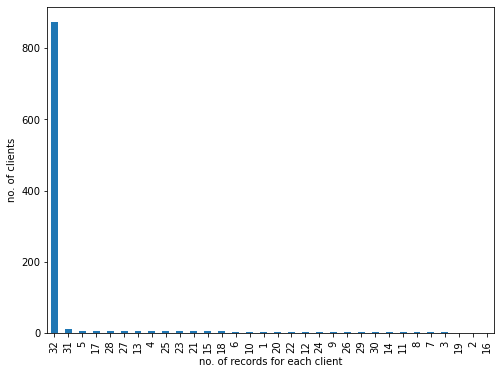

In [88]:
# # -- no. of records for each client

plt.figure()
ax = customers.groupby('client_nr')['yearmonth'].count().value_counts().plot(kind='bar');
ax.set_xlabel('no. of records for each client')
ax.set_ylabel('no. of clients')
plt.savefig('./figures/histogram_no_records_clients.png', bbox_inches='tight')

In [89]:
# # -- merge the tables

data = pd.merge( customers, crdt_applctn, how='inner', on=['client_nr','yearmonth'] )

# # -- separate year and month 
data["year"] = data.yearmonth.apply(lambda x: int(str(x)[:4]))
data["month"] = data.yearmonth.apply(lambda x: int(str(x)[-2:]))

# # -- remove clients with only a few records
data = data.groupby('client_nr').filter(lambda x: len(x) > 31)

data.head()

,client_nr,yearmonth,total_nr_trx,nr_debit_trx,volume_debit_trx,nr_credit_trx,volume_credit_trx,min_balance,max_balance,CRG,credit_application,nr_credit_applications,year,month
0,1,201401,97,50,6527929,47,7454863,-7914288,25110651,1.0,0,0,2014,1
1,1,201402,88,59,3475918,29,1895848,-8448513,25036651,1.0,0,0,2014,2
2,1,201403,96,62,31316405,34,20083583,-10347650,18020151,1.0,0,0,2014,3
3,1,201404,83,53,18669967,30,1091295,-15385039,13318200,1.0,0,0,2014,4
4,1,201405,94,54,2893905,40,2034075,-15682170,2350000,1.0,0,0,2014,5


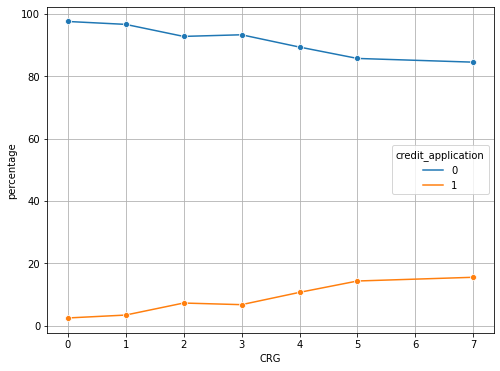

In [90]:
# # -- relation between CRG and credit application
# # -- probably we could have fill the missing values with 1 instead of 0
# # -- clients with higher CRG, tend to apply more for credit 

grp_crg_crdt_applcn = data.groupby('CRG')['credit_application'].value_counts(normalize=True)*100
grp_crg_crdt_applcn = grp_crg_crdt_applcn.reset_index(name='percentage')
grp_crg_crdt_applcn
sns.lineplot(data=grp_crg_crdt_applcn, x='CRG', y='percentage', hue='credit_application', marker='o');
plt.grid()
# sns_plot.savefig('./figures/CRG_vs_credit_application.png', bbox_inches='tight')

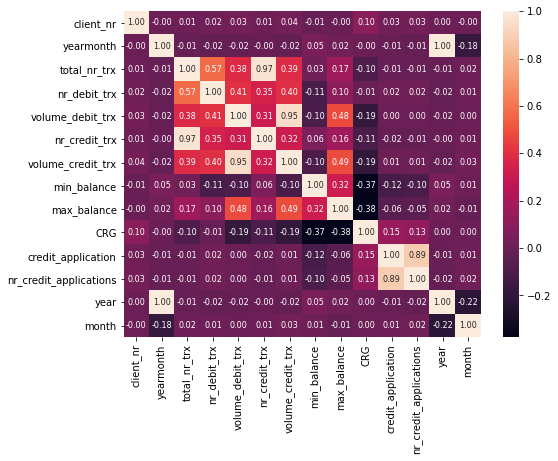

In [91]:
# # -- correlation of data

corr = data.corr()
sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={"fontsize": 8})
plt.savefig('./figures/correlation_org_data.png',  bbox_inches='tight')

### Shift the labels by one
#### Goal: predict a certain client will apply _next month_ or not.

In [92]:
data['credit_application'] = data.groupby('client_nr')['credit_application'].shift(-1)
data['nr_credit_applications'] = data.groupby('client_nr')['nr_credit_applications'].shift(-1)
data = data.dropna()

### Split train and test
- Train the model on all data except the last month; it is for test

In [93]:
# # -- split the train and test data

idx_test = (data.year==2016) & (data.month>=7)

data_test = data.loc[idx_test,:]
data_train = data.loc[~idx_test,:]

In [94]:

# # -- exclude correlated or extra columns
except_cols=['yearmonth','credit_application','nr_credit_applications','client_nr','year']

X_train = data_train[data_train.columns[~data_train.columns.isin(except_cols)]]
X_test = data_test[data_test.columns[~data_test.columns.isin(except_cols)]]

y_train = data_train['credit_application']
y_test = data_test['credit_application']

In [95]:
# # -- we could use oversampling to balance the data

oversample = SMOTE(sampling_strategy=0.8)
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)
y_train.value_counts(), y_train_smote.value_counts()

(0.0    24321
 1.0     1839
 Name: credit_application, dtype: int64,
 0.0    24321
 1.0    19456
 Name: credit_application, dtype: int64)

### ROC AUC multiple classifiers

[10:16:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


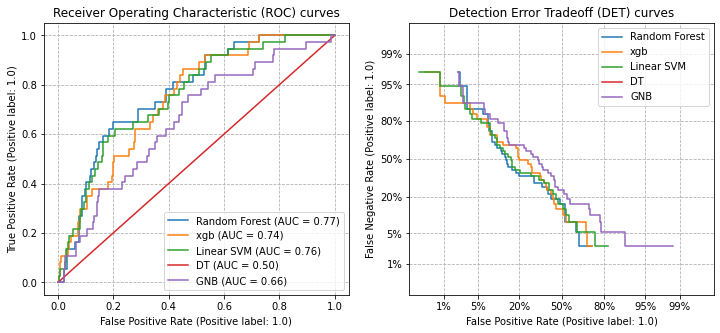

In [96]:

classifiers = {
        "Random Forest": RandomForestClassifier(max_depth=5, n_estimators=100, max_features=1, class_weight='balanced', random_state=49),
    'xgb': XGBClassifier(use_label_encoder=False),
    "Linear SVM": make_pipeline(StandardScaler(), LinearSVC(C=0.025, class_weight='balanced')),
    "DT": DecisionTreeClassifier(class_weight='balanced'),
    'GNB': GaussianNB(),
}

# prepare plots
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(12, 5))

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    # clf.fit(X_train_smote, y_train_smote)

    plot_roc_curve(clf, X_test, y_test, ax=ax_roc, name=name)
    plot_det_curve(clf, X_test, y_test, ax=ax_det, name=name)

ax_roc.set_title('Receiver Operating Characteristic (ROC) curves')
ax_det.set_title('Detection Error Tradeoff (DET) curves')

ax_roc.grid(linestyle='--')
ax_det.grid(linestyle='--')

plt.legend()
# plt.savefig('./figures/roc_auc_org_features_models.png',  bbox_inches='tight')
plt.show()

[[440 395]
 [  7  30]]


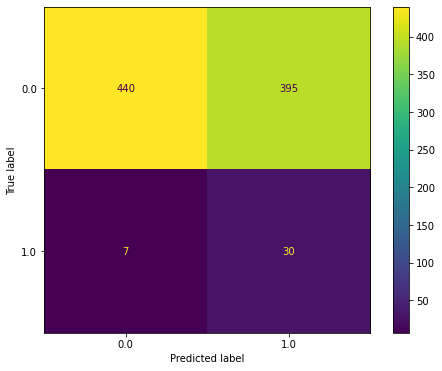

In [97]:
# # -- train a model on the orgiginal imbalanced data

clf = RandomForestClassifier(max_depth=4, n_estimators=100, max_features=1, class_weight='balanced', random_state=49)
clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)
print(confusion_matrix(y_test, y_hat))
plot_confusion_matrix(clf, X_test, y_test)

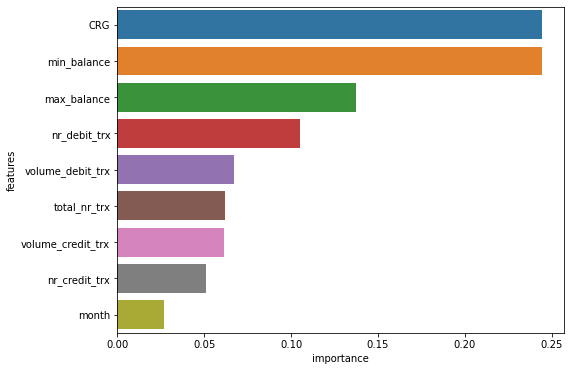

In [98]:
# # -- feature importance 

df = pd.DataFrame({'features':X_train.columns, 'importance':clf.feature_importances_})
df = df.sort_values('importance',ascending=False)
sns.barplot(data=df, y='features',x='importance');
plt.savefig('./figures/org_feature_importance.png',bbox_inches='tight')

[[473 362]
 [  7  30]]


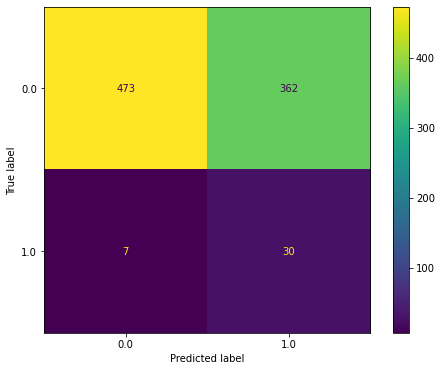

In [99]:
# # -- train a model on the orgiginal oversampled balanced data

clf_smote = RandomForestClassifier(max_depth=4, n_estimators=100, max_features=1, class_weight='balanced', random_state=49)
clf_smote.fit(X_train_smote, y_train_smote)

y_hat = clf_smote.predict(X_test)
print(confusion_matrix(y_test, y_hat))
plot_confusion_matrix(clf_smote, X_test, y_test)

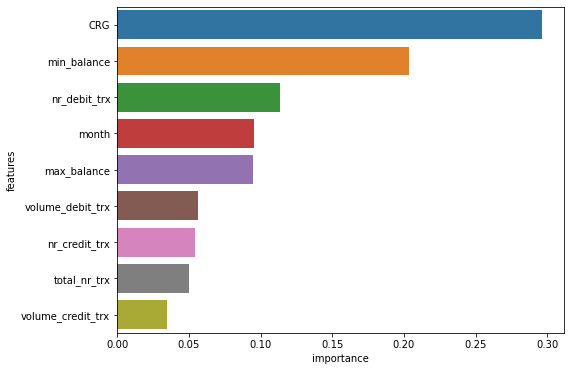

In [100]:
# # -- feature importance 

df = pd.DataFrame({'features':X_train.columns, 'importance':clf_smote.feature_importances_})
df = df.sort_values('importance',ascending=False)
sns.barplot(data=df, y='features',x='importance');
# plt.savefig('./figures/org_feature_importance.png',bbox_inches='tight')

In [101]:
# # -- save the last model as a pickle file

filename = './models/model_org_features_balanced.sav'
pickle.dump(clf, open(filename, 'wb'))

In [103]:
# stop here

raise SystemExit("Stop right here!")

SystemExit: Stop right here!

In [54]:

ddd

## Grid search for hyperparameters tuning

In [76]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

linear_classifier = RandomForestClassifier(random_state=49, class_weight='balanced', n_jobs=-1 ) 
param_grid = { 
    'n_estimators': [50,100,150],
    'max_features': [1,2,'auto'],
    'max_depth' : [4,5,6],
    'criterion' :['gini', 'entropy'] 
    }
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
    }

def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=5)
    grid_search = GridSearchCV(linear_classifier, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train.values, y_train.values)

    # make the predictions
    y_pred = grid_search.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

grid_search_precision_score = grid_search_wrapper(refit_score='precision_score')

KeyboardInterrupt: 